In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=411efe0c6c3e1cb307a0807dd047820542656ab50bfdc73b94f76bafbb5b48db
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import *
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

In [29]:
jupyter nbconvert --to html your_notebook.ipynb

SyntaxError: ignored

In [3]:
# Start Spark Session
spark = SparkSession.builder \
    .master("local") \
    .appName("Video Game Sales Analysis") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

# Read the CSV file
df = spark.read.csv('/content/vgsales.csv', header=True, inferSchema=True)

# Show first 20 rows
df.show(20)

+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform|            Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing|            Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports|            Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing|            Nintendo|   11.27|    8.89|   10.22|  

In [4]:
df_1 = spark.read.option("header", "true").option("mode", "DROPMALFORMED").csv("/content/vgsales.csv")
df.fillna(value=0).show()

+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform|            Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing|            Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports|            Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing|            Nintendo|   11.27|    8.89|   10.22|  

In [5]:
df.fillna(value=-99, subset=["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]).show()


+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|Rank|                Name|Platform|Year|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|
+----+--------------------+--------+----+------------+--------------------+--------+--------+--------+-----------+------------+
|   1|          Wii Sports|     Wii|2006|      Sports|            Nintendo|   41.49|   29.02|    3.77|       8.46|       82.74|
|   2|   Super Mario Bros.|     NES|1985|    Platform|            Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|
|   3|      Mario Kart Wii|     Wii|2008|      Racing|            Nintendo|   15.85|   12.88|    3.79|       3.31|       35.82|
|   4|   Wii Sports Resort|     Wii|2009|      Sports|            Nintendo|   15.75|   11.01|    3.28|       2.96|        33.0|
|   5|Pokemon Red/Pokem...|      GB|1996|Role-Playing|            Nintendo|   11.27|    8.89|   10.22|  

In [6]:
# Calculate Descriptive Statistics
quantitative_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# Calculate Mean
mean_values = df.select(*[F.mean(col).alias(f'mean_{col}') for col in quantitative_columns]).collect()[0]

# Calculate Median
median_values = df.select(*[F.expr(f'percentile_approx({col}, 0.5)').alias(f'median_{col}') for col in quantitative_columns]).collect()[0]

# Calculate Standard Deviation
stddev_values = df.select(*[F.stddev(col).alias(f'stddev_{col}') for col in quantitative_columns]).collect()[0]

# Display Descriptive Statistics
for col in quantitative_columns:
    print(f"{col} - Mean: {mean_values[f'mean_{col}']:.2f}, Median: {median_values[f'median_{col}']:.2f}, Std Dev: {stddev_values[f'stddev_{col}']:.2f}")


NA_Sales - Mean: 0.26, Median: 0.08, Std Dev: 0.82
EU_Sales - Mean: 0.15, Median: 0.02, Std Dev: 0.51
JP_Sales - Mean: 0.08, Median: 0.00, Std Dev: 0.31
Other_Sales - Mean: 0.05, Median: 0.01, Std Dev: 0.19
Global_Sales - Mean: 0.54, Median: 0.17, Std Dev: 1.56


In [7]:
# Data Exploration
# Total number of rows and columns
print('Rows:', df.count())
print('Columns:', len(df.columns))

Rows: 16598
Columns: 11


In [8]:
# Creating a Pandas DataFrame for plotting
pandas_df = df.toPandas()



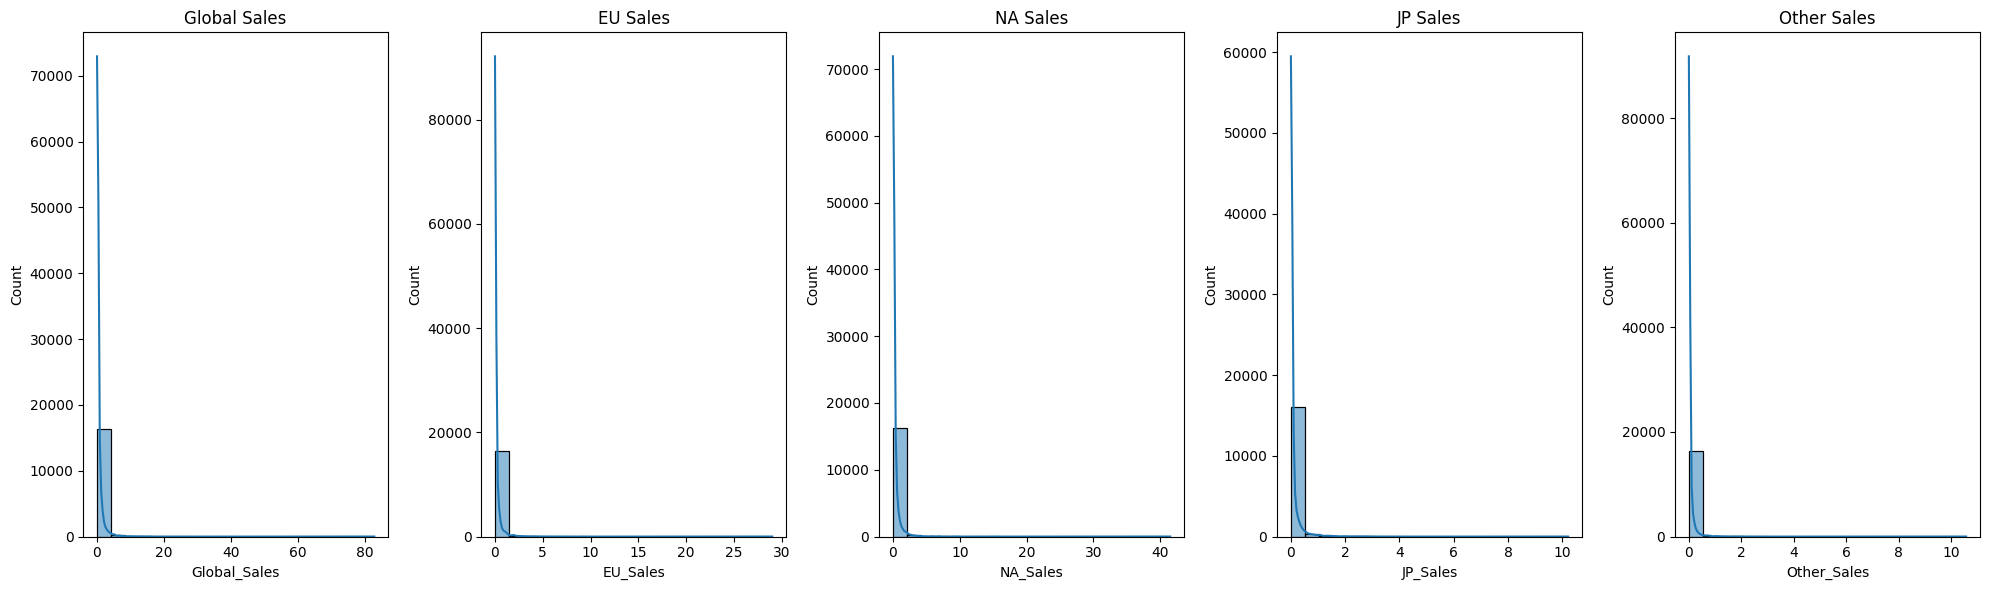

In [9]:
# Plotting histograms using Seaborn in the same row
plt.figure(figsize=(20, 6))

plt.subplot(1, 5, 1)
sns.histplot(pandas_df['Global_Sales'], bins=20, kde=True)
plt.title("Global Sales")

plt.subplot(1, 5, 2)
sns.histplot(pandas_df['EU_Sales'], bins=20, kde=True)
plt.title("EU Sales")

plt.subplot(1, 5, 3)
sns.histplot(pandas_df['NA_Sales'], bins=20, kde=True)
plt.title("NA Sales")

plt.subplot(1, 5, 4)
sns.histplot(pandas_df['JP_Sales'], bins=20, kde=True)
plt.title("JP Sales")

plt.subplot(1, 5, 5)
sns.histplot(pandas_df['Other_Sales'], bins=20, kde=True)
plt.title("Other Sales")

plt.tight_layout()
plt.show()


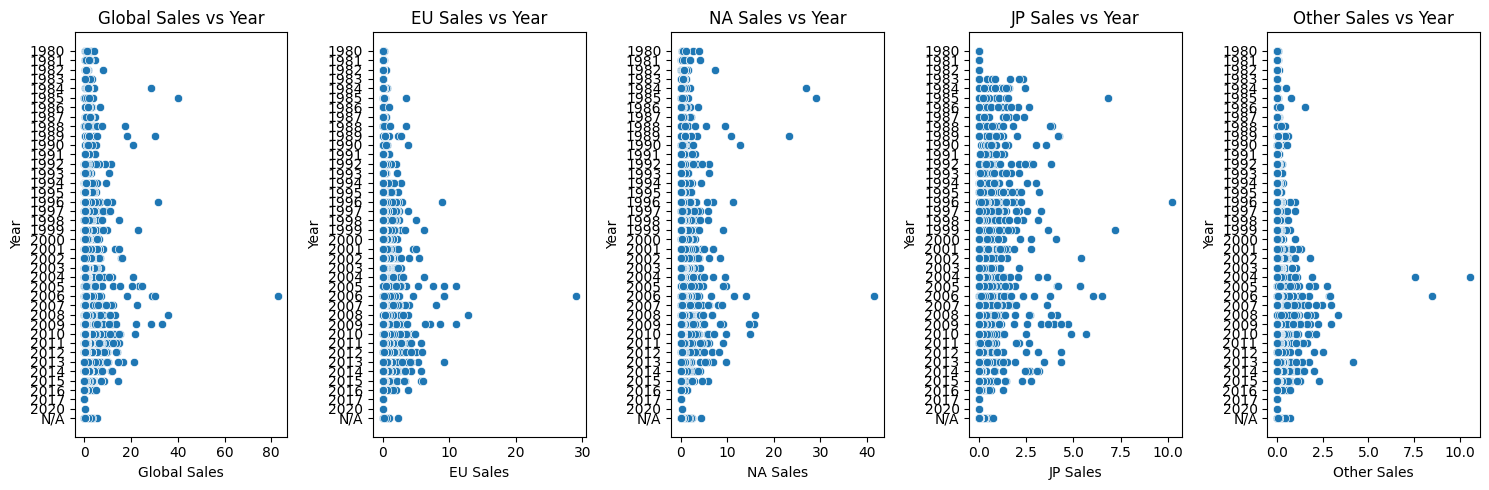

In [10]:
# Scatter plots using Seaborn in the same row
plt.figure(figsize=(15, 5))

# Global Sales vs Year
plt.subplot(1, 5, 1)
sns.scatterplot(x='Global_Sales', y='Year', data=pandas_df.sort_values('Year'))
plt.title("Global Sales vs Year")
plt.xlabel("Global Sales")
plt.ylabel("Year")

# EU Sales vs Year
plt.subplot(1, 5, 2)
sns.scatterplot(x='EU_Sales', y='Year', data=pandas_df.sort_values('Year'))
plt.title("EU Sales vs Year")
plt.xlabel("EU Sales")
plt.ylabel("Year")

# NA Sales vs Year
plt.subplot(1, 5, 3)
sns.scatterplot(x='NA_Sales', y='Year', data=pandas_df.sort_values('Year'))
plt.title("NA Sales vs Year")
plt.xlabel("NA Sales")
plt.ylabel("Year")

# JP Sales vs Year
plt.subplot(1, 5, 4)
sns.scatterplot(x='JP_Sales', y='Year', data=pandas_df.sort_values('Year'))
plt.title("JP Sales vs Year")
plt.xlabel("JP Sales")
plt.ylabel("Year")

# Other Sales vs Year
plt.subplot(1, 5, 5)
sns.scatterplot(x='Other_Sales', y='Year', data=pandas_df.sort_values('Year'))
plt.title("Other Sales vs Year")
plt.xlabel("Other Sales")
plt.ylabel("Year")

plt.tight_layout()
plt.show()


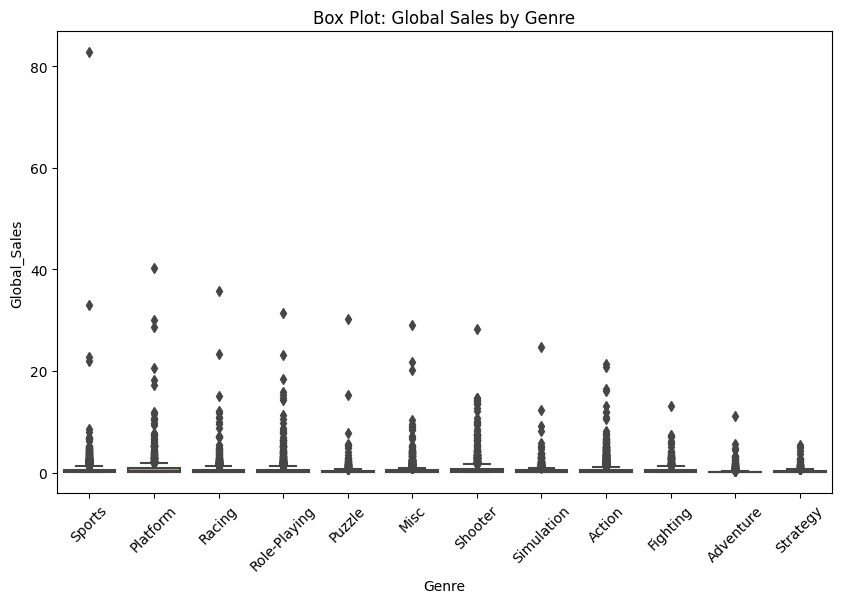

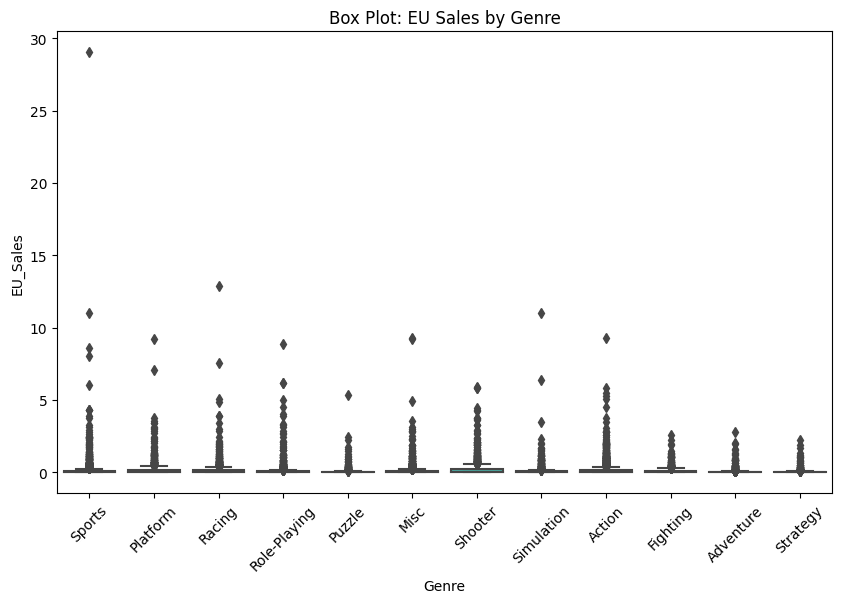

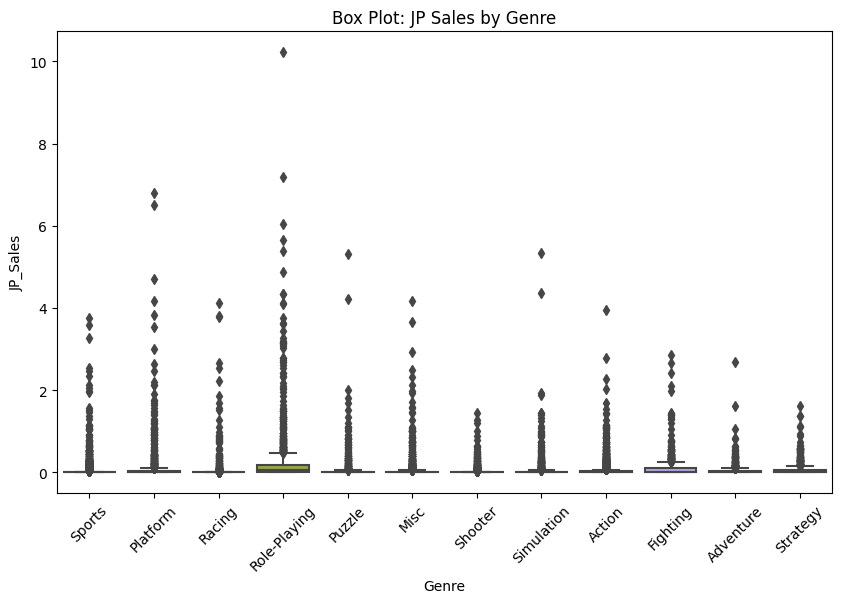

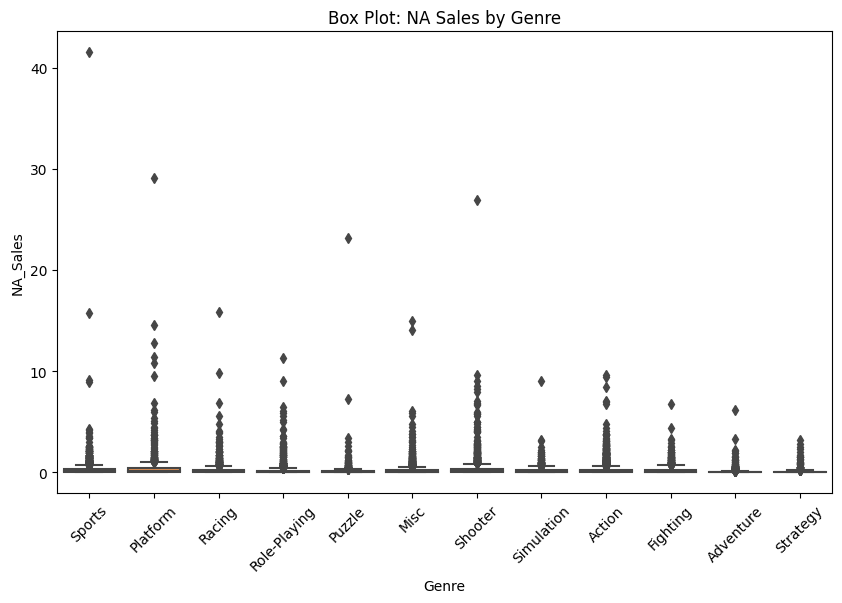

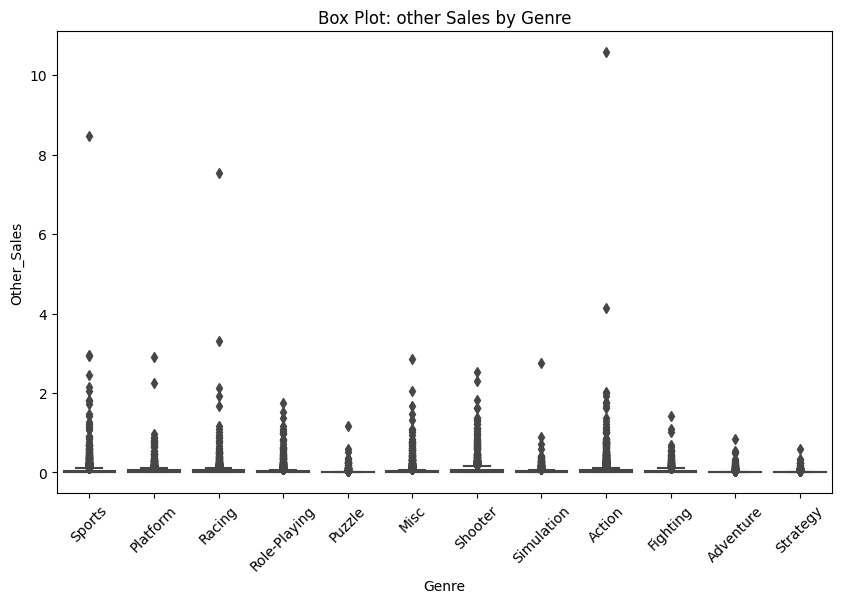

In [11]:
# Box plot using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Global_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("Box Plot: Global Sales by Genre")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='EU_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("Box Plot: EU Sales by Genre")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='JP_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("Box Plot: JP Sales by Genre")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='NA_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("Box Plot: NA Sales by Genre")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Genre', y='Other_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("Box Plot: other Sales by Genre")
plt.show()

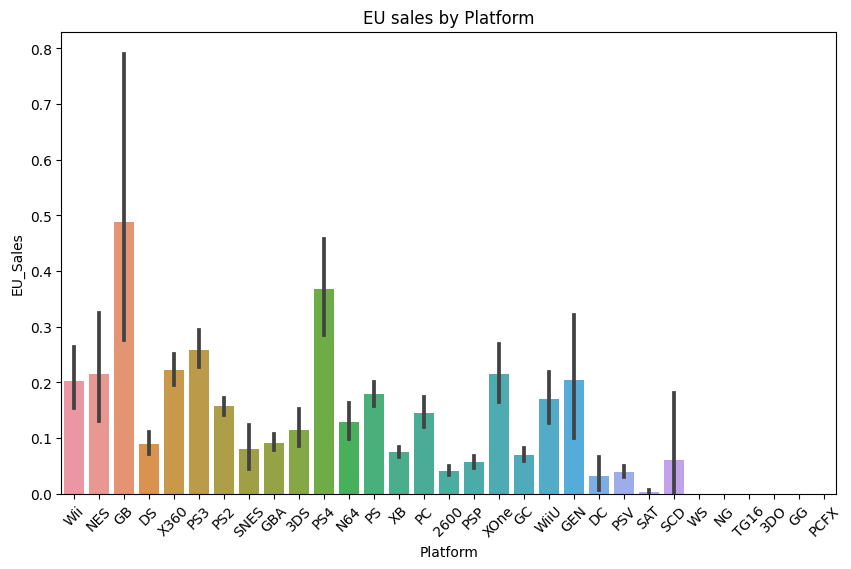

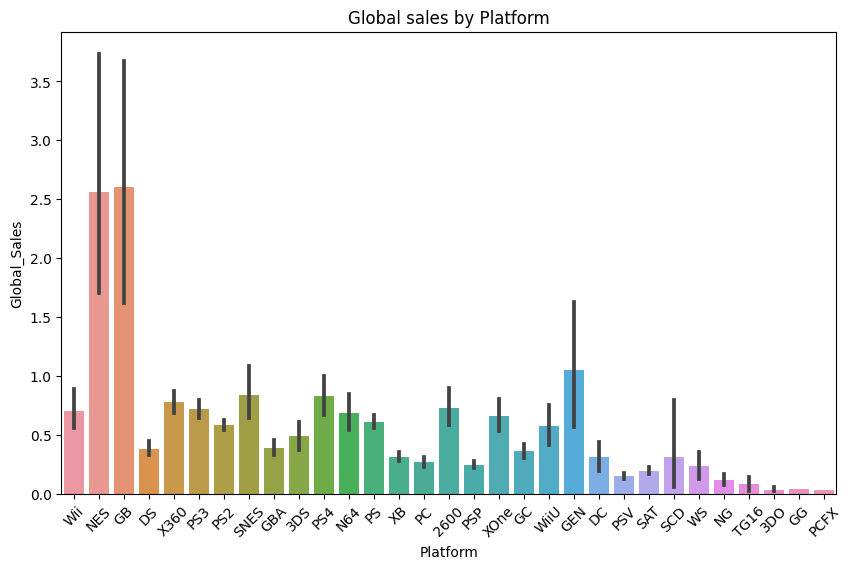

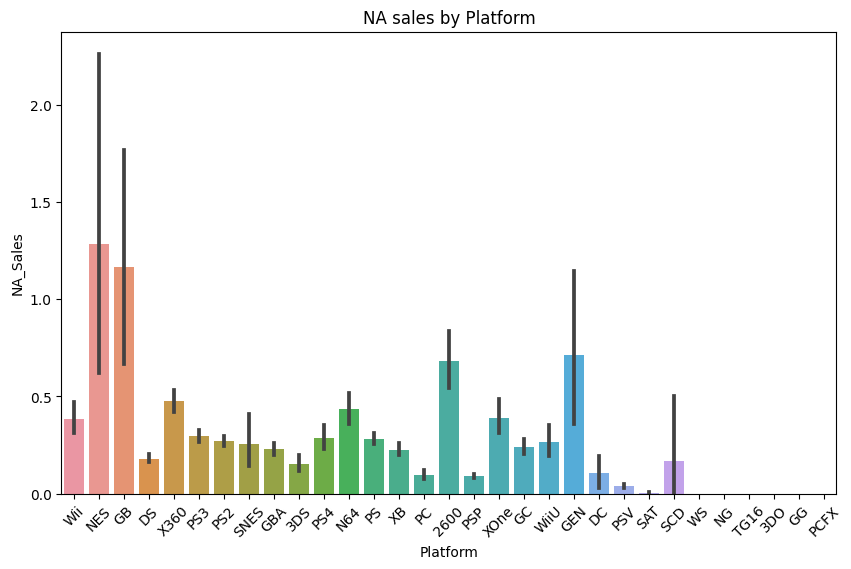

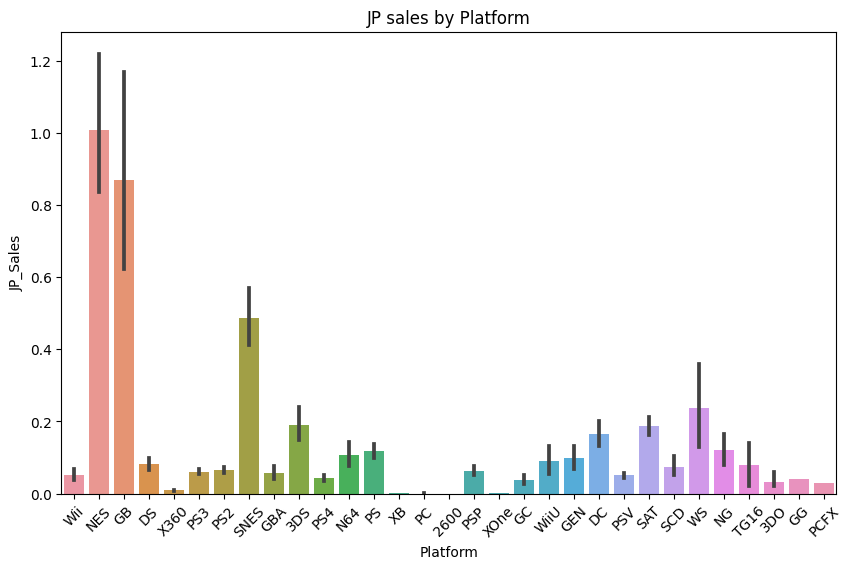

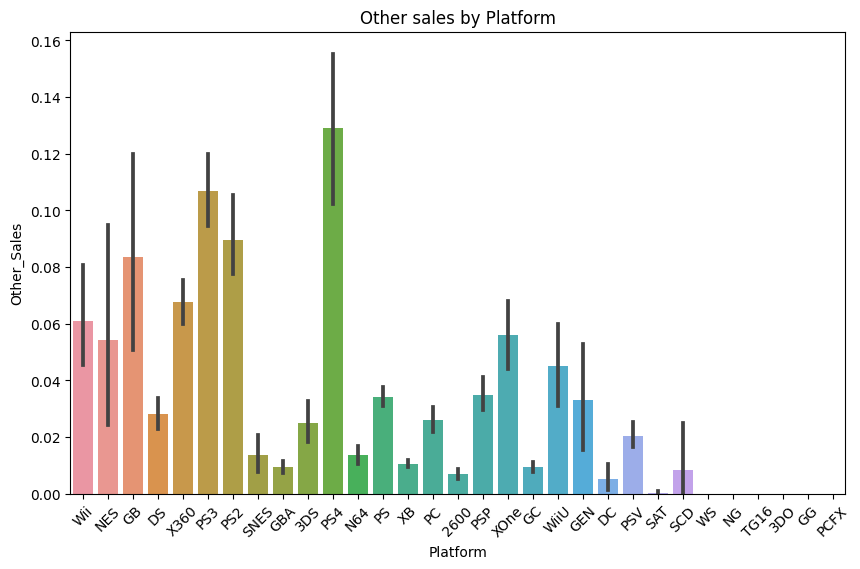

In [12]:
# Creating bar plots using Matplotlib
plt.figure(figsize=(10, 6))
sns.barplot(x='Platform', y='EU_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("EU sales by Platform")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Platform', y='Global_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("Global sales by Platform")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Platform', y='NA_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("NA sales by Platform")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Platform', y='JP_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("JP sales by Platform")
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x='Platform', y='Other_Sales', data=pandas_df)
plt.xticks(rotation=45)
plt.title("Other sales by Platform")
plt.show()







In [13]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# Select relevant columns for correlation analysis
correlation_columns = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# Create a VectorAssembler to combine the columns into a single feature column
assembler = VectorAssembler(inputCols=correlation_columns, outputCol="features")
data_for_correlation = assembler.transform(df).select("features")

# Calculate correlation matrix
correlation_matrix = Correlation.corr(data_for_correlation, "features").collect()[0][0]

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
DenseMatrix([[1.        , 0.76772675, 0.44978741, 0.63473727, 0.94104736],
             [0.76772675, 1.        , 0.43558445, 0.72638489, 0.90283581],
             [0.44978741, 0.43558445, 1.        , 0.29018625, 0.61181552],
             [0.63473727, 0.72638489, 0.29018625, 1.        , 0.74833085],
             [0.94104736, 0.90283581, 0.61181552, 0.74833085, 1.        ]])


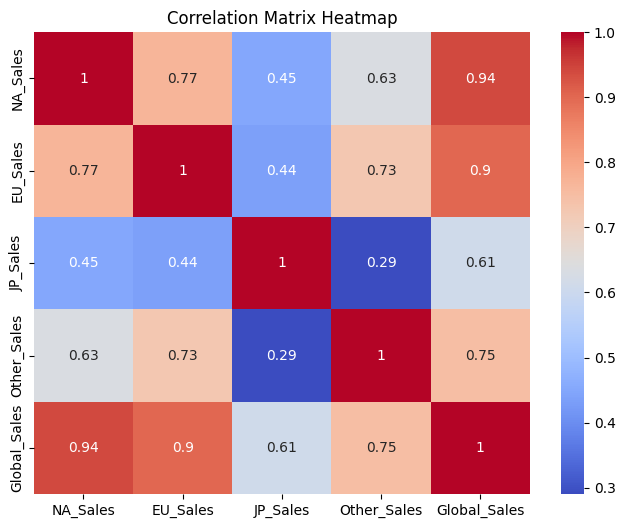

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the correlation matrix from a Row object to a NumPy array
correlation_matrix = np.array(correlation_matrix.toArray())

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=correlation_columns, yticklabels=correlation_columns)
plt.title("Correlation Matrix Heatmap")
plt.show()


In [15]:
# Unique Values in 'genre' Column
df.select('Genre').distinct().show()

+------------+
|       Genre|
+------------+
|   Adventure|
|      Sports|
|      Racing|
|Role-Playing|
|     Shooter|
|        Misc|
|    Platform|
|      Puzzle|
|    Fighting|
|      Action|
|    Strategy|
|  Simulation|
+------------+



In [16]:
# Distribution of values inside column 'genre'
df.groupBy('genre').count().show()

+------------+-----+
|       genre|count|
+------------+-----+
|   Adventure| 1286|
|      Sports| 2346|
|      Racing| 1249|
|Role-Playing| 1488|
|     Shooter| 1310|
|        Misc| 1739|
|    Platform|  886|
|      Puzzle|  582|
|    Fighting|  848|
|      Action| 3316|
|    Strategy|  681|
|  Simulation|  867|
+------------+-----+



In [17]:
# Unique Values in 'Platform' Column
df.select('Platform').distinct().show()

+--------+
|Platform|
+--------+
|     3DO|
|      PC|
|     PS3|
|     NES|
|      PS|
|      DC|
|     GEN|
|     PS2|
|     3DS|
|    PCFX|
|      GG|
|    WiiU|
|    SNES|
|      GB|
|     SCD|
|     N64|
|     PS4|
|     PSP|
|    2600|
|    XOne|
+--------+
only showing top 20 rows



In [18]:
# Distribution of values inside column 'Platform'
df.groupBy('Platform').count().show()

+--------+-----+
|Platform|count|
+--------+-----+
|     3DO|    3|
|      PC|  960|
|     PS3| 1329|
|     NES|   98|
|      PS| 1196|
|      DC|   52|
|     GEN|   27|
|     PS2| 2161|
|     3DS|  509|
|    PCFX|    1|
|      GG|    1|
|    WiiU|  143|
|    SNES|  239|
|      GB|   98|
|     SCD|    6|
|     N64|  319|
|     PS4|  336|
|     PSP| 1213|
|    2600|  133|
|    XOne|  213|
+--------+-----+
only showing top 20 rows



In [19]:
# Question 1: Top 3 Video Games in sports that Sell the most Globally
df.select('Name', 'Global_Sales').where(df.Genre == 'Sports').orderBy('Global_Sales', ascending=False).show(3)

+-----------------+------------+
|             Name|Global_Sales|
+-----------------+------------+
|       Wii Sports|       82.74|
|Wii Sports Resort|        33.0|
|          Wii Fit|       22.72|
+-----------------+------------+
only showing top 3 rows



In [20]:
# Question 2: Top 5 Publisher in Racing who Have highest sale in Europe
df.select('Publisher', 'EU_Sales').filter(df.Genre == 'Racing').orderBy('EU_Sales', ascending=False).show(5)

+--------------------+--------+
|           Publisher|EU_Sales|
+--------------------+--------+
|            Nintendo|   12.88|
|            Nintendo|    7.57|
|Sony Computer Ent...|    5.09|
|Sony Computer Ent...|    4.88|
|            Nintendo|    3.91|
+--------------------+--------+
only showing top 5 rows



In [21]:
# Question 3: Name 5 lowest Sales Publisher Globally
df.select('Publisher', 'Global_Sales').orderBy('Global_Sales', ascending=True).show(5)

+--------------------+------------+
|           Publisher|Global_Sales|
+--------------------+------------+
|          Touchstone|        0.01|
|             Nobilis|        0.01|
|Nippon Ichi Software|        0.01|
|  Namco Bandai Games|        0.01|
|     Electronic Arts|        0.01|
+--------------------+------------+
only showing top 5 rows



In [22]:
# Question 4: Average sale for various genres
df.groupBy('Genre').agg(F.round(F.mean('Global_Sales'), 2).alias('average_sales')).show()

+------------+-------------+
|       Genre|average_sales|
+------------+-------------+
|   Adventure|         0.19|
|      Sports|         0.57|
|      Racing|         0.59|
|Role-Playing|         0.62|
|     Shooter|         0.79|
|        Misc|         0.47|
|    Platform|         0.94|
|      Puzzle|         0.42|
|    Fighting|         0.53|
|      Action|         0.53|
|    Strategy|         0.26|
|  Simulation|         0.45|
+------------+-------------+



In [23]:
# Question 5: List of Name with sale in 2015
df.select('Name', 'Publisher', 'Global_Sales').where(df.Year == '2015').orderBy('Global_Sales', ascending=False).show()

+--------------------+--------------------+------------+
|                Name|           Publisher|Global_Sales|
+--------------------+--------------------+------------+
|Call of Duty: Bla...|          Activision|       14.24|
|             FIFA 16|     Electronic Arts|        8.49|
|Star Wars Battlef...|     Electronic Arts|        7.67|
|Call of Duty: Bla...|          Activision|         7.3|
|           Fallout 4|  Bethesda Softworks|        6.96|
|            Splatoon|            Nintendo|        4.57|
|Uncharted: The Na...|Sony Computer Ent...|        4.47|
|   Halo 5: Guardians|Microsoft Game St...|        4.26|
|           Fallout 4|  Bethesda Softworks|        4.09|
|            NBA 2K16|Take-Two Interactive|        3.85|
|Batman: Arkham Kn...|Warner Bros. Inte...|        3.79|
|The Witcher 3: Wi...|  Namco Bandai Games|        3.73|
|Star Wars Battlef...|     Electronic Arts|        3.49|
|Metal Gear Solid ...|Konami Digital En...|        3.38|
|Assassin's Creed ...|         

In [24]:
# Describe the DataFrame
df.describe().show()

+-------+-----------------+--------------------+--------+------------------+--------+---------------+-------------------+------------------+-------------------+--------------------+------------------+
|summary|             Rank|                Name|Platform|              Year|   Genre|      Publisher|           NA_Sales|          EU_Sales|           JP_Sales|         Other_Sales|      Global_Sales|
+-------+-----------------+--------------------+--------+------------------+--------+---------------+-------------------+------------------+-------------------+--------------------+------------------+
|  count|            16598|               16598|   16598|             16598|   16598|          16598|              16598|             16598|              16598|               16598|             16598|
|   mean|8300.605253645017|              1942.0|  2600.0|2006.4064433147546|    null|           null|0.26466742981084057|0.1466520062658483|0.07778166044101108|0.048063019640913515|  0.53744065550

In [25]:
# Linear Regression Analysis
data = df.select("NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales").dropna()
feature_columns = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
lr = LinearRegression(featuresCol="features", labelCol="Global_Sales")
pipeline = Pipeline(stages=[lr])
lr_model = pipeline.fit(train_data)
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol="Global_Sales", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Linear Regression RMSE:", rmse)
lr_coefficients = lr_model.stages[-1].coefficients
print("Linear Regression Coefficients:", lr_coefficients)

Linear Regression RMSE: 0.005268710142527473
Linear Regression Coefficients: [0.9999544028780193,1.0000392692552083,0.9999137696590534,0.9992546028167025]


In [26]:
# Logistic Regression Analysis
data = df.select("NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales").dropna()
data = data.withColumn("TopSeller", (data["Global_Sales"] > 1).cast("int"))
feature_columns = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
lr = LogisticRegression(featuresCol="features", labelCol="TopSeller")
pipeline = Pipeline(stages=[lr])
lr_model = pipeline.fit(train_data)
predictions = lr_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="TopSeller")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Logistic Regression Area under ROC:", accuracy)

Logistic Regression Area under ROC: 1.0


In [27]:
# Random Forest Classifier Analysis
data = df.select("NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales").dropna()
data = data.withColumn("TopSeller", (data["Global_Sales"] > 1).cast("int"))
feature_columns = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)
rf = RandomForestClassifier(featuresCol="features", labelCol="TopSeller")
pipeline = Pipeline(stages=[rf])
rf_model = pipeline.fit(train_data)
predictions = rf_model.transform(test_data)
evaluator = BinaryClassificationEvaluator(labelCol="TopSeller")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
print("Random Forest Classifier Area under ROC:", accuracy)



Random Forest Classifier Area under ROC: 0.997757187166054


In [28]:

# Stop the Spark session
spark.stop()